# Introduction to FGC: Simple Use Cases

This tutorial is an introduction on how to use the Forest-Guided Clustering python package to interpret your Random Forest model. We will show you:

1. how to install the Forest-Guided Clustering package
2. how to apply the Forest-Guided Clustering package to your trained Random Forest model
3. how to use the output visualizations for interpretation of your Random Forest model


**Note:** The Forest-Guided Clustering method provides insight into the structure of the data by identifying the features that guide the decision process of the Random Forest model. If the trained Random Forest model shows a poor performance, e.g. accuracy of 70% or lower, and therefore, makes poor decisions, the retrieved feature importance might not reflect the true underlying structures in the data.

**Installation:**

To use the Forest-Guided Clustering you have to install the fgclustering package first. Please visit the [Read the Docs - Installation](https://forest-guided-clustering.readthedocs.io/en/latest/_getting_started/installation.html) page for instructions.


**Imports:**

In [1]:
## Import the Forest-Guided Clustering package
from fgclustering import FgClustering

## Imports for datasets
from palmerpenguins import load_penguins
from sklearn.datasets import load_breast_cancer, fetch_california_housing

## Additional imports for use-cases
import joblib
import pandas as pd

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV

## Use Case 1: FGC for Random Forest Classifier (binary classification)

The first use-case is a simple binary classification Random Forest model. The Random Forest classifier is trained based on the Breast Cancer dataset from ```sklearn.datasets``` (for more details please see descrption [here](https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-dataset)). This dataset contains 569 samples of 212 malignant (class 0) and 357 benign (class 1) tumors. Tumors are described by 30 numeric features computed from a digitized image taken of breast mass.

In [2]:
data_breast_cancer = load_breast_cancer(as_frame=True)
data_breast_cancer = data_breast_cancer.frame
data_breast_cancer['target'] = data_breast_cancer['target'].map({0: 'malignant', 1: 'benign'})
data_breast_cancer.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,malignant
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,malignant
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,malignant
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,malignant
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,malignant


We trained a Random Forest Classifier on the whole dataset and tuned the hyperparameters via 5 fold cross-validation, where we optimized the parameters: ```max_depth``` and ```max_features```. For the sake of simplicity and due to the availability of an out-of-bag score, we did not use train / test splits.

In [3]:
X_breast_cancer = data_breast_cancer.loc[:, data_breast_cancer.columns != 'target']
y_breast_cancer = data_breast_cancer.target

classifier = RandomForestClassifier(max_samples=0.8, bootstrap=True, oob_score=True, random_state=42)

grid = {'max_depth':[2, 5], 'max_features': ['sqrt', 'log2']}
grid_classifier = GridSearchCV(classifier, grid, cv=5)
grid_classifier.fit(X_breast_cancer, y_breast_cancer)
rf_breast_cancer = grid_classifier.best_estimator_

print(f'Parameters of best prediction model: {grid_classifier.best_params_}')
print(f'OOB accuracy of prediction model: {round(rf_breast_cancer.oob_score_,3)}')

Parameters of best prediction model: {'max_depth': 5, 'max_features': 'sqrt'}
OOB accuracy of prediction model: 0.954


Now we apply the Forest-Guided Clustering method to understand which features play an important role for the classification of tumors into malignant and benign. We use the pre-processed breast cancer dataset and trained Random Forest Classifier as input for an ```FgClustering``` object. We have to indicate which column of the dataset contains the target values in the ```target_column``` parameter. If the target column is part of the dataset, the string with the column name is passed. If the target variable is not part of the dataset, the vector of target values is passed.

Optional parameters are:

- ```random_state```: Seed number for random state, defaults to 42


In [4]:
fgc = FgClustering(model=rf_breast_cancer, data=data_breast_cancer, target_column='target')

Interpreting RandomForestClassifier


To run the Forest-Guided Clustering method we have to execute the ```run()``` function. This function will calculate the optimal number of clusters as well as the corresponding global and local feature importance for the obtained clusters. Those values are defined as $\text{feature importance} = - log10(\text{p-value} + \epsilon) / - log10(\epsilon)$, where the p-value indicates the significance of the difference between cluster-wise feature distributions (global feature importance) or the significance that the feature values attributed to a cluster are not randomly drawn from the full feature distribution (local feature importance). 

This function has several optional parameters:

- ```number_of_clusters```: Number of clusters for the k-medoids clustering. Leave *None* if number of clusters should be optimized, defaults to None
- ```max_K```: Maximum number of clusters for cluster score computation, defaults to 8
- ```method_clustering```: Which algorithm to use, defaults to 'pam'. Use 'fasterpam' for big datasets. See python [kmedoids documentation](https://python-kmedoids.readthedocs.io/en/latest/) for other implemented methods.
- ```init_clustering```: Specify medoid initialization method. See python [kmedoids documentation](https://python-kmedoids.readthedocs.io/en/latest/) for parameter description, defaults to 'random'
- ```max_iter_clustering```: Number of iterations for k-medoids clustering, defaults to 100
- ```discart_value_JI```: Minimum Jaccard Index for cluster stability. Note: a Jaccard Index < 0.6 indicates that the observed pattern is not stable anymore, defaults to 0.6 
- ```bootstraps_JI```: Number of bootstraps to compute the Jaccard Index, defaults to 100
- ```bootstraps_p_value```: Number of bootstraps to compute the p-value of feature importance, defaults to 100
- ```n_jobs```:  maximum number of jobs to run in parallel when creating bootstraps to compute the Jaccard index. n_jobs=1 means no parallel computing is used, defaults to 1
- ```verbose```: print the output of fgc cluster optimization process (the Jaccard index and score for each cluster number); defaults to 1 (printing). Set to 0 for no outputs


If the parameter ```number_of_clusters``` is not specified, the ```run()``` function will compute the optimal number of clusters based on a scoring function that consideres the class mixture of the cluster, the so-called *score* and the cluster stability, the so-called *Jaccard Index*. The lower the *score* the better the separation of target values between cluster (e.g. classes that are well mixed within single clusters imply a high score, while having only one class within each cluster would lead to a low score). The lower the *Jaccard Index* the lower the cluster stability, e.g. if we repeat the clustering on a subsample of the original dataset we will get a very different clustering. The *Jaccard Index* returns values between 0 (unstable) and 1 (stable), where 0.6 is suggested as a minimal cutoff for stability, i.e. clusters with a *Jaccard Index* > 0.6 are considered as indicating patterns in the data (see [here](https://forest-guided-clustering.readthedocs.io/en/latest/_theoretical_background/general_algorithm.html#optimize-number-of-clusters) for further explanations). 

After optimizing the number of clusters, the k-Medoids clustering algorithm is applied to the distance matrix (which is computed from the Random Forest proximity matrix) where k is the optimal number of clusters. 

In [5]:
fgc.run()

 17%|█▋        | 1/6 [00:01<00:06,  1.26s/it]

For number of cluster 2 the Jaccard Index is 0.9977762891115787
For number of cluster 2 the score is 0.06613635989234057


 33%|███▎      | 2/6 [00:02<00:05,  1.34s/it]

For number of cluster 3 the Jaccard Index is 0.8861827734206449
For number of cluster 3 the score is 0.07478999977783318


 50%|█████     | 3/6 [00:04<00:05,  1.77s/it]

For number of cluster 4 the Jaccard Index is 0.5036478848646798
Clustering is instable, no score computed!


 67%|██████▋   | 4/6 [00:08<00:04,  2.41s/it]

For number of cluster 5 the Jaccard Index is 0.5934978039560798
Clustering is instable, no score computed!


 83%|████████▎ | 5/6 [00:12<00:03,  3.13s/it]

For number of cluster 6 the Jaccard Index is 0.33292910886203164
Clustering is instable, no score computed!


100%|██████████| 6/6 [00:18<00:00,  3.02s/it]

For number of cluster 7 the Jaccard Index is 0.43566831779331777
Clustering is instable, no score computed!
Optimal number of cluster is: 2


The optimal number of clusters for the breast cancer dataset is *k=2*. We can see from the output above that *k=2* leads to the lowest *score* of 0.066 while having a *Jaccard Index* of 0.99, which means that the clustering is almost perfectly stable. The clustering with k=3 has a stable clustering as well but higher scores, and hence, the seperation of target values between clusters is less god, e.g. higher class-mixture within a cluster. The clusterings with 4+ clusters have a *Jaccard Index* < 0.6 and hence are defined unstable and not considered for the choice of the optimal k.

In a second step, we use the significance of the difference between cluster-wise feature distributions as a measure of global feature importance (ANOVA for continuous features and chi square for categorical features). Features that have significantly different distributions across clusters have a high feature importance, while features that have a similar feature distribution across clusters have a low feature importance. Those features are considered to be less important in the decision making process of the Random Forest model (see description [here](https://forest-guided-clustering.readthedocs.io/en/latest/_theoretical_background/feature_importance.html#global-feature-importance) for further explanations).

In addition to the global feature importance, we also provide a local feature importance which gives the importance of each feature for each cluster. Here, a feature is considered important if its distribution in a particlular cluster is clearly different from the feature distribution in the whole dataset. E.g. if the feature values in a certain cluster would be spread over the whole feature range, the feature would not be considered important for the interpretation of the clusters because it does not show any trend or pattern that differentiates the clusters and hence, we would not be able to draw any clear conclusions from it (see description [here](https://forest-guided-clustering.readthedocs.io/en/latest/_theoretical_background/feature_importance.html#local-feature-importance) for further explanations).


To plot the global and local feature importance, we run the ```plot_feature_importance()``` function. The resulting plots can be saved by setting the ```save``` parameter. 

Optional parameters are:

- ```thr_pvalue```: p-value threshold for display, defaults to 1
- ```top_n```: Number of top features to display in the plot
- ```num_cols```: Number of plots per row in the output figure

The plot below shows that most features except the last four show significant differences across clusters for global feature importance and that both clusters have some important features in common. However, for cluster 1 much less features show a clear pattern than for cluster 0.

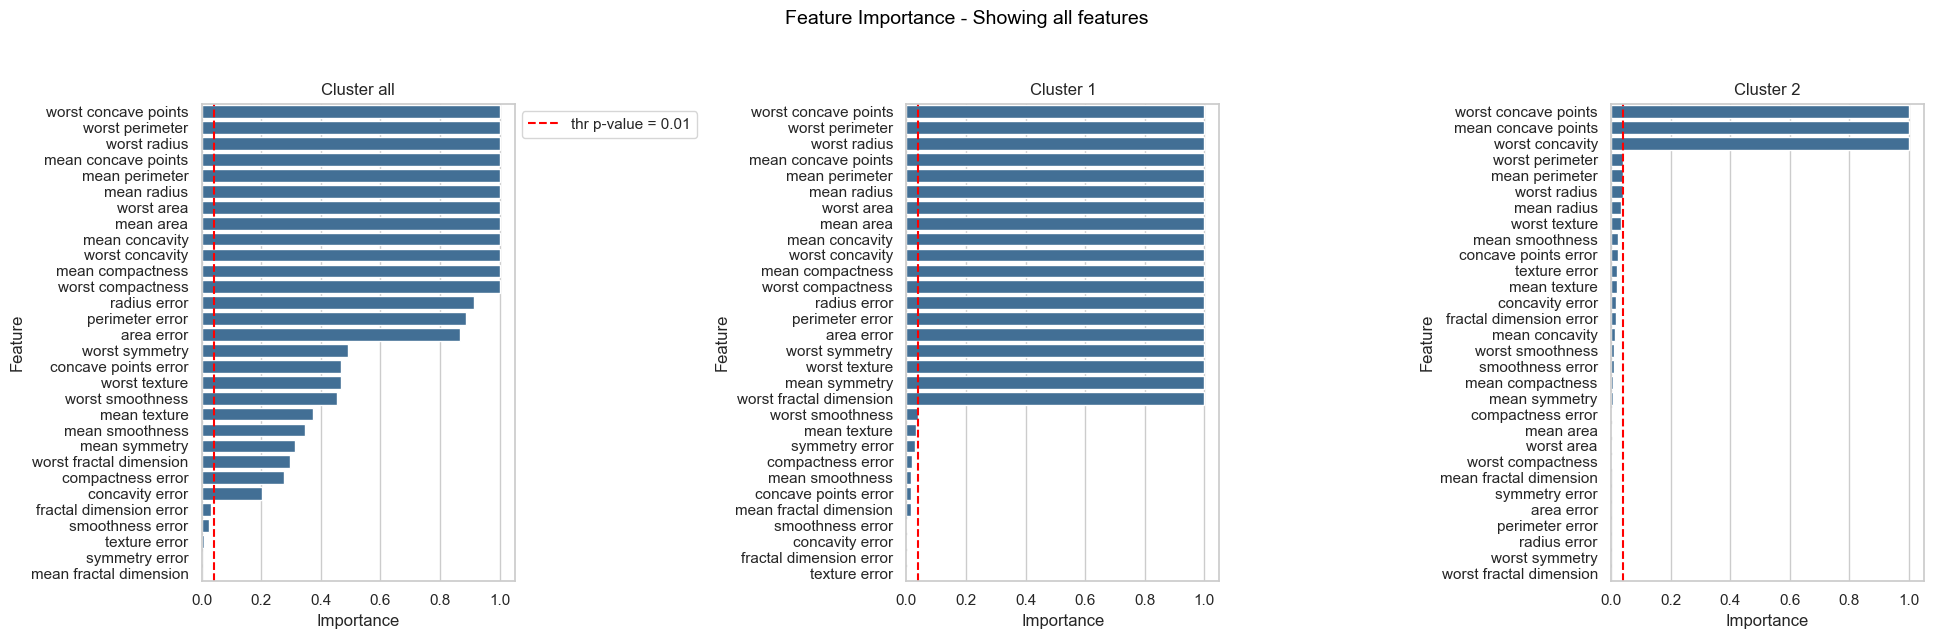

In [6]:
fgc.plot_feature_importance(thr_pvalue=0.01)

Forest-Guided Clustering provides the special option to visualize the decision path of a Random Forest model, reflecting the decision making process of that model in a heatmap summary plot and a feature-wise distribution plot. The heatmap provides a general overview on the target value attribution and feature enrichment / depletion per cluster.  We can see which classes/target values fall into which cluster and samples that fall into the "wrong" cluster can be inspected further as they might be extreme outliers or wrongly labelled samples / measurement errors. The distribution plots contain the same information as the heatmap just presented in a different way. Here the features are not standardized and we can see the actual scale of each feature on the y axis. Furthermore, we get an idea of the distribution of feature values within each cluster, e.g. having a small or high within-cluster-variation. 

To plot the decision path, we run the ```plot_decision_paths()``` function. The resulting plots can be saved by setting the ```save``` parameter. 

Optional parameters are:

- ```thr_pvalue```: p-value threshold for global feature importance filtering, defaults to 1 (no filtering)
- ```distributions```: plot the distributions of each feature passing the significance threshold for filtering, defaults to True
- ```heatmap```: plot the heatmap with features passing the significance threshold for filtering, defaults to True

Here, we don't pre-filter the features by global feature importance to show that the last four features, which were identified as non-important by the global feature importance, indeed don't show any considerable difference in feature values across clusters.

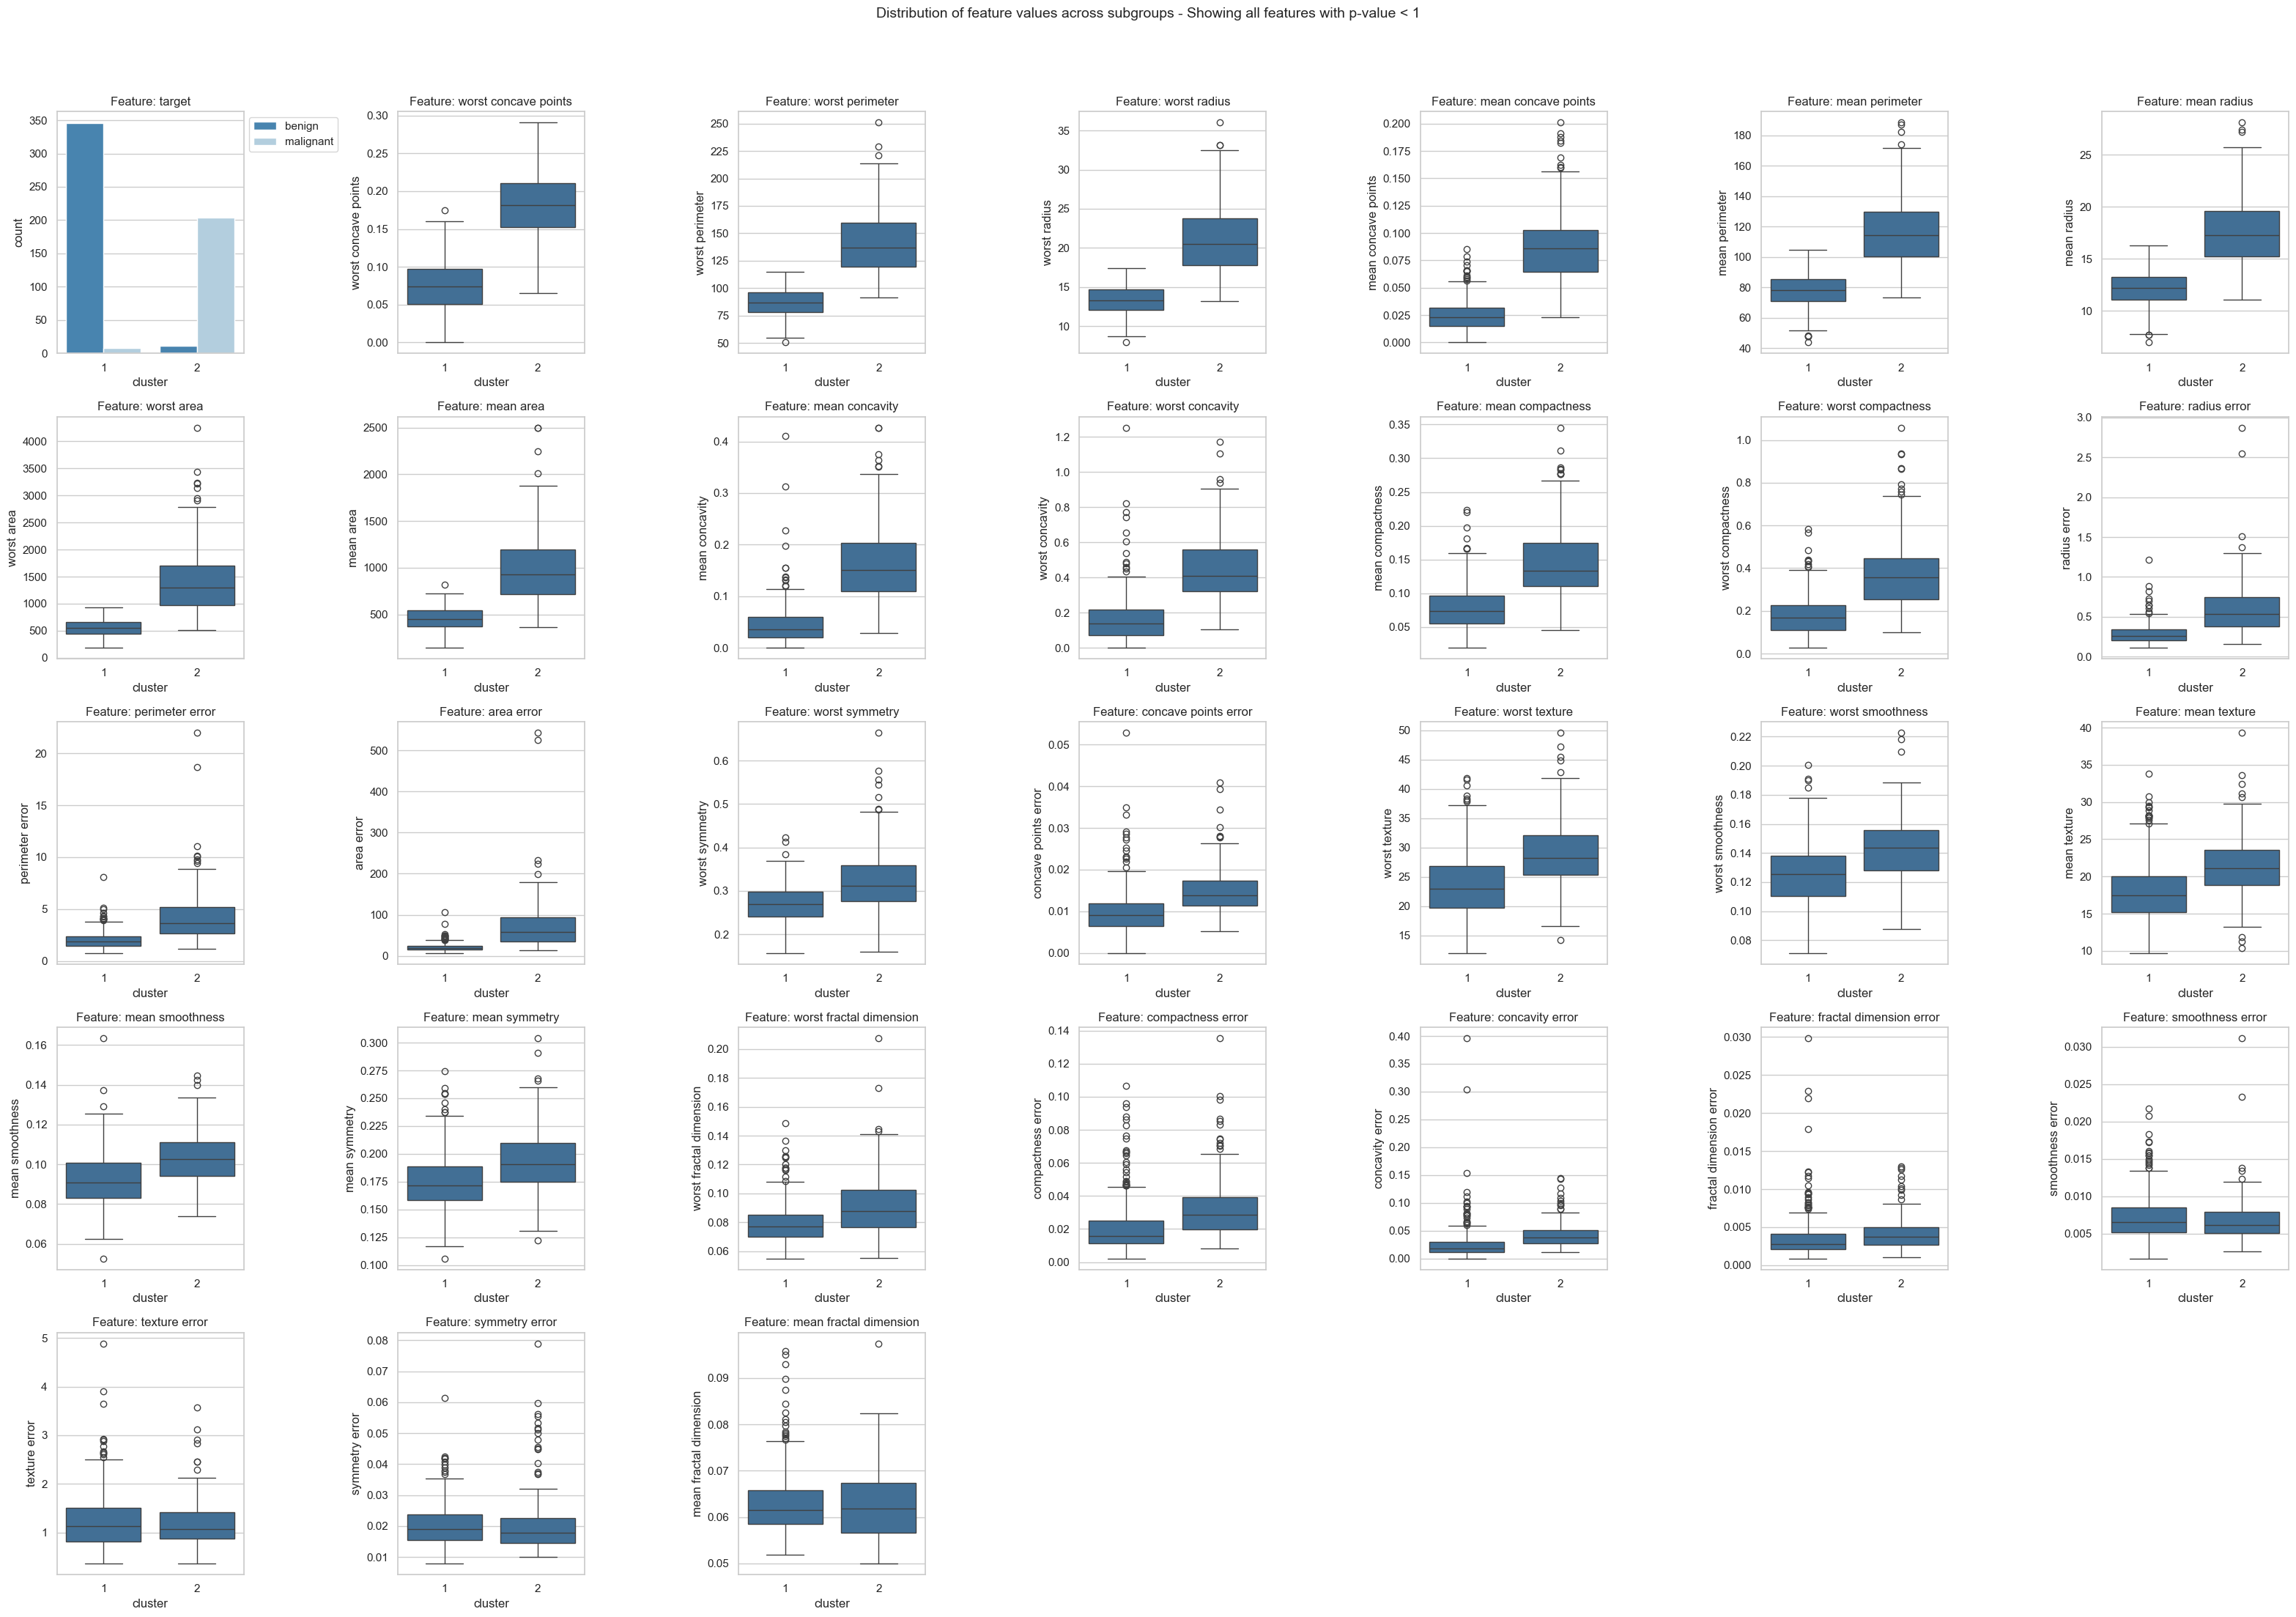

/Users/lisa.barros/Desktop/fg-clustering/fgclustering/plotting.py:150: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_heatmap = pd.concat(


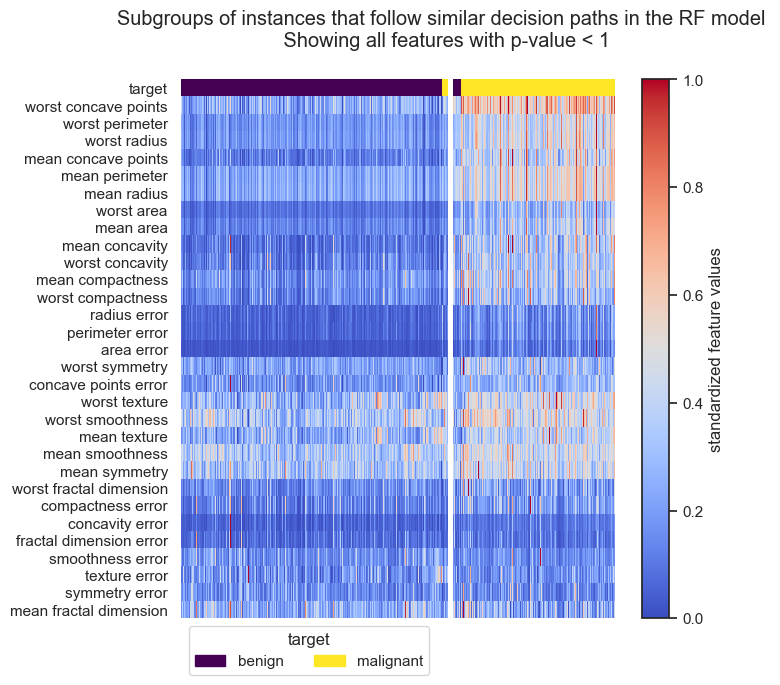

In [7]:
fgc.plot_decision_paths(thr_pvalue=1, num_cols = 7) 

From the resulting plots we can draw the following conclusions for malignent and benign tumors:

- The two classes are almost perfectly attributed to the two clusters. Only a few samples fall into the "wrong" cluster, which could be further inspected to rule out labelling errors.
- The top ranked features in the boxplots and feature importance show the biggest difference of feature values between cluster.
- Cluster 0 samples (benign tumors) have lower values for all important features than cluster 1 samples (malignant tumors), i.e. malignent tumors have more worst concave points, a higher compactness and a larger radius and perimeter.

## Use Case 2: FGC for Random Forest Classifier (multiclass classification)

The second use-case illustrates how Forest-Guided Clustering can be used to interpret a multi-class classificiation model. The Random Forest classifier is trained on the Penguin dataset from ```palmerpenguins``` (for more details please see descrption [here](https://github.com/mcnakhaee/palmerpenguins)). This dataset contains 344 penguins observed on islands in the Palmer Archipelago near Palmer Station, Antarctica. The dataset contains three classes of penguins: 146 Adelie, 68 Chinstrap and 119 Gentoo penguins. The penguins are described by different characteristics, such as size measurements, clutch observations, blood isotope ratios and sex, encoded in numeric and categorical features.

In [8]:
data_penguins = load_penguins()

# Remove the instances with missing values and check how many we are left with
print(f"Before omiting the missing values the dataset has {data_penguins.shape[0]} instances")
data_penguins.dropna(inplace=True)
print(f"After omiting the missing values the dataset has {data_penguins.shape[0]} instances")

data_penguins.head()

Before omiting the missing values the dataset has 344 instances
After omiting the missing values the dataset has 333 instances


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007


We trained a Random Forest Classifier on the whole dataset and tuned the hyperparameters via 5 fold cross-validation, where we optimized the parameters: ```max_depth``` and ```max_features```. For the sake of simplicity and due to the availability of an out-of-bag score, we did not use train / test splits. To use the categorical feature for our Random Forest Classifier, we one-hot encode those features, using dummy encoding.

In [9]:
# preprocess categorical features such that they can be used for the RF model
data_penguins_encoded = pd.get_dummies(data_penguins, columns=['island', 'sex'], prefix=['island', 'sex'], drop_first=True)

X_penguins = data_penguins_encoded.loc[:, data_penguins_encoded.columns != 'species']
y_penguins = data_penguins_encoded.species

classifier = RandomForestClassifier(max_samples=0.8, bootstrap=True, oob_score=True, random_state=42)

grid = {'max_depth':[2, 5], 'max_features': ['sqrt', 'log2']}
grid_classifier = GridSearchCV(classifier, grid, cv=5)
grid_classifier.fit(X_penguins, y_penguins)
rf_penguins = grid_classifier.best_estimator_

print(f'Parameters of best prediction model: {grid_classifier.best_params_}')
print(f'OOB accuracy of prediction model: {round(rf_penguins.oob_score_,3)}')

Parameters of best prediction model: {'max_depth': 5, 'max_features': 'sqrt'}
OOB accuracy of prediction model: 0.985


We apply the Forest-Guided Clustering method to understand which characteristics play an important role for the classification of the different penguin species. We use the pre-processed penguins dataset and trained Random Forest Classifier as input for the ```FgClustering``` object and execute the ```run()``` function. For further description of the input parameters see binary classification example above.

In [10]:
fgc = FgClustering(model=rf_penguins, data=data_penguins_encoded, target_column='species')
fgc.run()

Interpreting RandomForestClassifier


 17%|█▋        | 1/6 [00:00<00:01,  3.35it/s]

For number of cluster 2 the Jaccard Index is 0.9160289493578838
For number of cluster 2 the score is 0.32933697175607646


 33%|███▎      | 2/6 [00:00<00:01,  2.54it/s]

For number of cluster 3 the Jaccard Index is 0.9952883877989059
For number of cluster 3 the score is 0.018666445142142996


 50%|█████     | 3/6 [00:01<00:01,  1.93it/s]

For number of cluster 4 the Jaccard Index is 0.9718654376806184
For number of cluster 4 the score is 0.07721157852502875


 67%|██████▋   | 4/6 [00:02<00:01,  1.31it/s]

For number of cluster 5 the Jaccard Index is 0.542860857827226
Clustering is instable, no score computed!


 83%|████████▎ | 5/6 [00:04<00:01,  1.01s/it]

For number of cluster 6 the Jaccard Index is 0.8737253192050606
For number of cluster 6 the score is 0.02112436148148152


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]

For number of cluster 7 the Jaccard Index is 0.4526426851667004
Clustering is instable, no score computed!
Optimal number of cluster is: 3


We can see from the output above that the optimal number of clusters is *k=3*, which leads to the lowest *score* while having a stable clustering. When plotting the global feature impotance, we can see that the encoded categorical features have one feature per encoding, i.e. the feature *island* has three categories (Dream, Torgersen and Biscoe) and is encoded by two dummy variables *island_Drean* and *island_Torgersen*. 

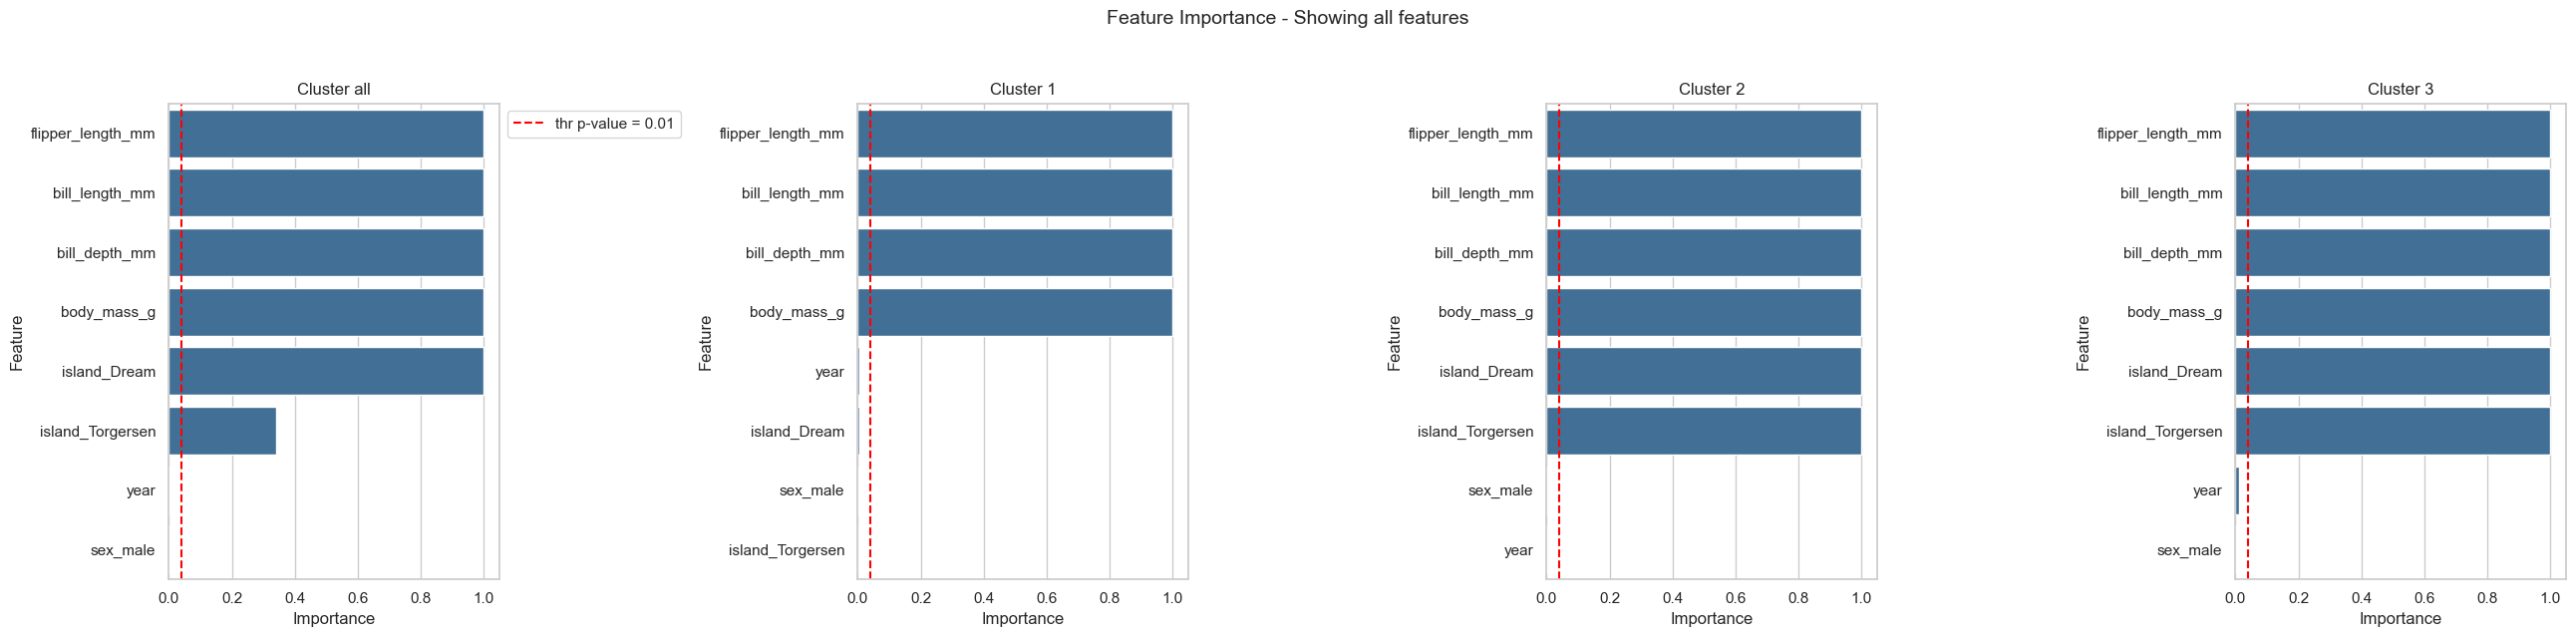

In [11]:
fgc.plot_feature_importance(thr_pvalue=0.01)

This encoding makes the interpretation of categorical features more difficult and prevents the usage of an appropriate test statistic for categorical features, e.g. the chi-square test. To overcome this problem, we can use a different feature matrix for the calculation of the test statistics on which the global and local feature importance as well as the decision path plots are based on. **Note:** the new feature matrix must have the same number of samples and the same ordering of samples as the original feature matrix to coincide with the calculated proximity matrix. In the case of our penguins dataset, we can exchange the dummy encoded features with the original categorical features and use the funtion ```calculate_statistics()``` to recalculate the p-values for each feature (over all clusters and per cluster) based on the new feature matrix.


In [12]:
data_penguins['island'] = data_penguins['island'].astype('category')
data_penguins['sex'] = data_penguins['sex'].astype('category')

fgc.calculate_statistics(data=data_penguins, target_column='species')

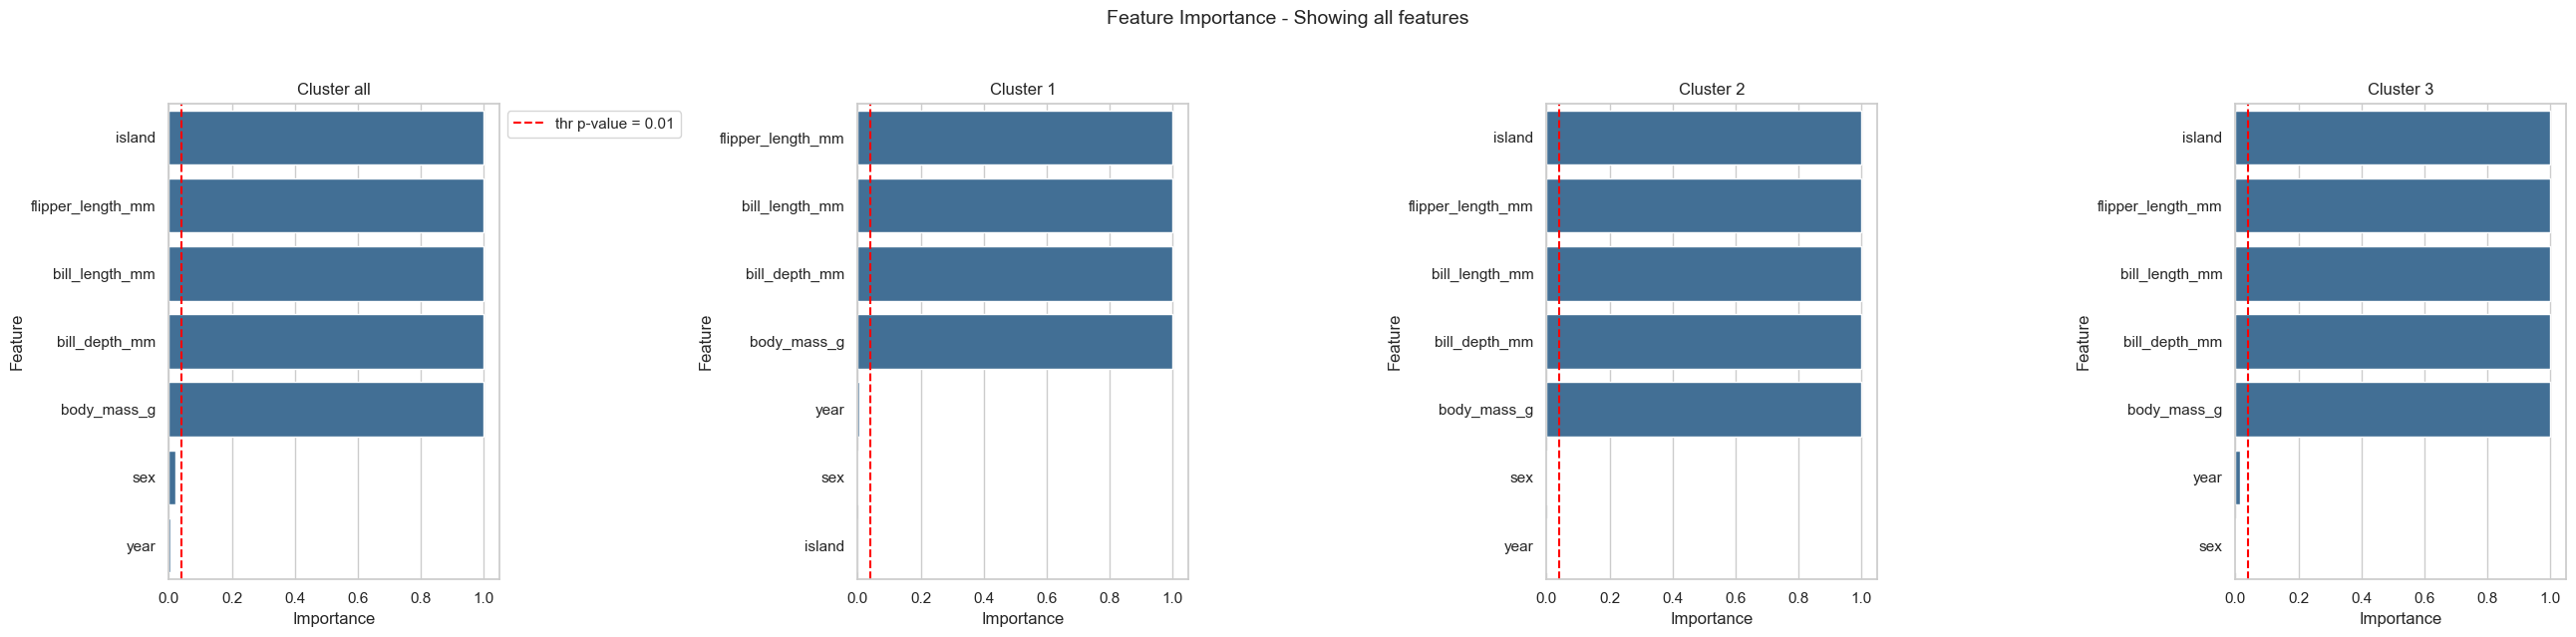

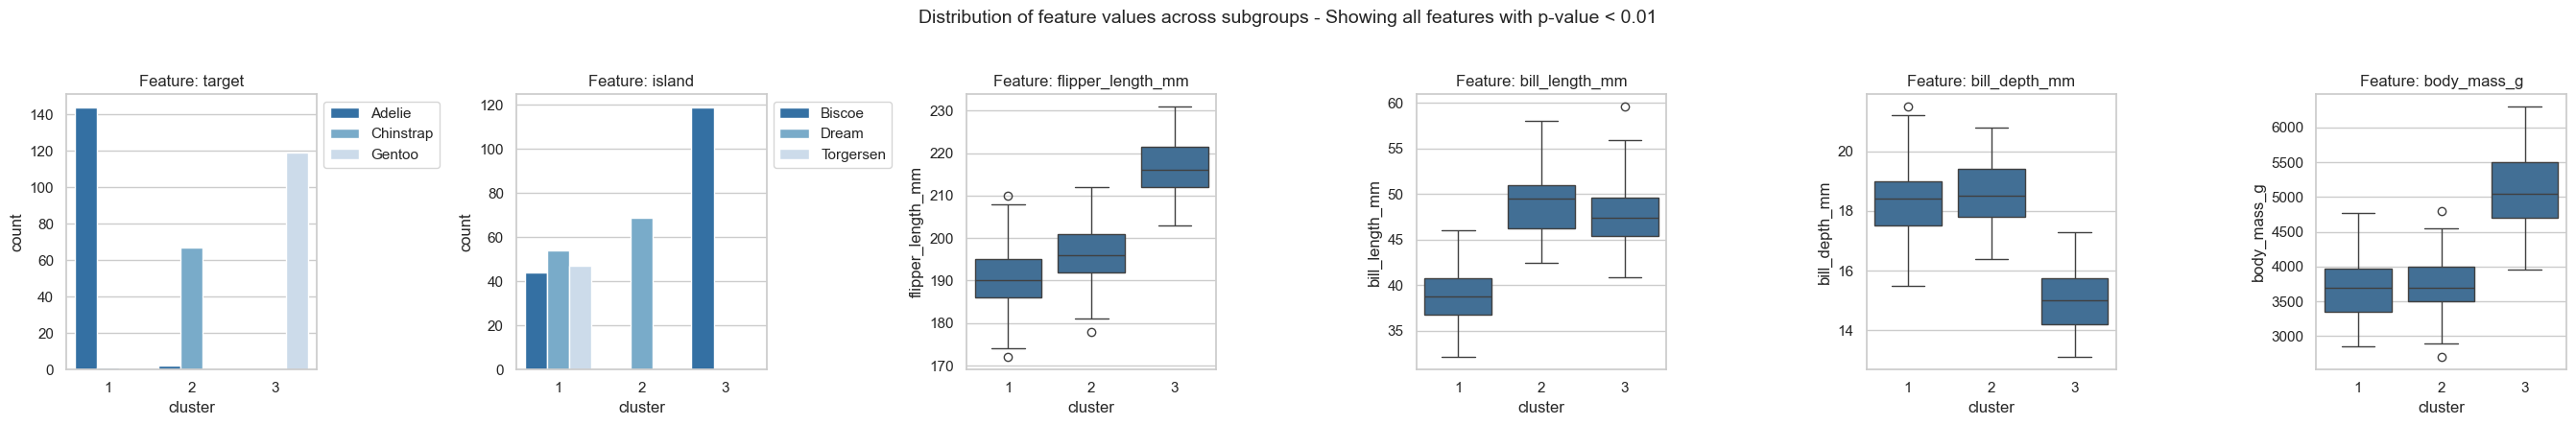

/Users/lisa.barros/Desktop/fg-clustering/fgclustering/plotting.py:150: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_heatmap = pd.concat(


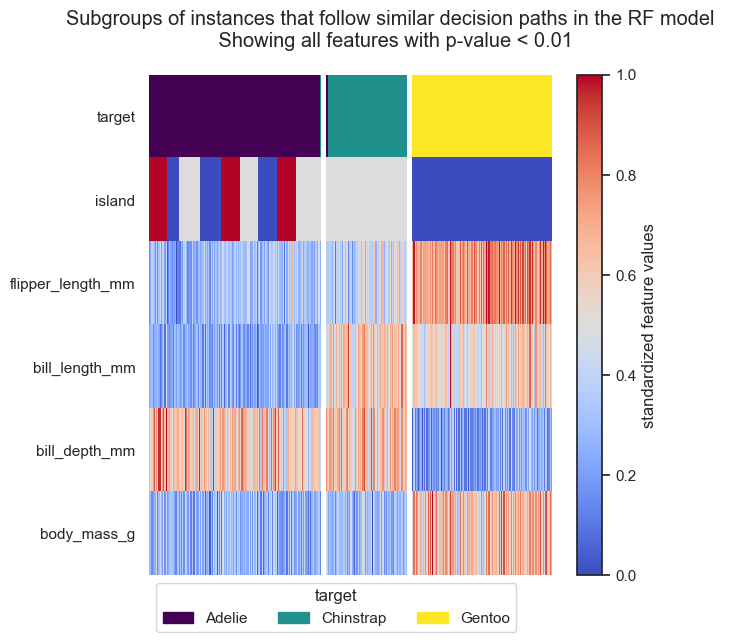

In [13]:
fgc.plot_feature_importance(thr_pvalue=0.01)
fgc.plot_decision_paths(thr_pvalue=0.01) #only plot relevant features

From the resulting plots we can draw the following conclusions:

- The three classes are almost perfectly attributed to the three clusters. Only a few samples of *Adelie* penguins fall into the "wrong" cluster, which could be further inspected.
- All features, except *year* and *sex*, are important for the clustering and show a clear trend within each cluster.
- Cluster 0 only contains *Adelie* penguins. *Adelie* penguins are found on all three islands and are described by a small flipper and bill length, a low body mass and a long bill depth. 
- Cluster 2 only contains *Gentoo* penguins. Those penguins show the opposite characteristics than *Adelie* penguins, i.e. long flipper and bill length, a high body mass but a short bill depth, but are only found the *Dream* island.
- Cluster 1 almost exclusively contains *Chinstrap* penguins. *Chinstrap* penguins have a small flipper length and body mass, but a long bill length and depth. Those penguins are exclusively found on the Biscoe island.

## Use Case 3: FGC for Random Forest Regressor

The third use-case illustrates how Forest-Guided Clustering can be used to interpret a regression model. The Random Forest Regressor is trained on the California Housing dataset from ```sklearn.datasets``` (for more details please see descrption [here](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset)). This dataset contains 20,640 median house values for California districts (expressed in $100,000), which are described by 8 numeric feature.

In [14]:
data_housing = fetch_california_housing(as_frame=True).frame

# for sake of runtime we only use the first 1000 samples
data_housing = data_housing.iloc[:1000]
data_housing.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


We trained a Random Forest Regressor on the whole dataset and tuned the hyperparameters via 5 fold cross-validation, where we optimized the parameters: ```max_depth``` and ```max_features```.  For the sake of simplicity and due to the availability of an out-of-bag score, we did not use train / test splits.

In [15]:
X_housing = data_housing.loc[:, data_housing.columns != 'MedHouseVal']
y_housing = data_housing.MedHouseVal

regressor = RandomForestRegressor(max_samples=0.8, bootstrap=True, oob_score=True, random_state=42)

grid = {'max_depth':[2, 5], 'max_features': ['sqrt', 'log2']}
grid_regressor = GridSearchCV(regressor, grid, cv=5)
grid_regressor.fit(X_housing, y_housing)
rf_housing = grid_regressor.best_estimator_

print(f'Parameters of best prediction model: {grid_regressor.best_params_}')
print(f'OOB R^2 of prediction model: {round(rf_housing.oob_score_,3)}')

Parameters of best prediction model: {'max_depth': 5, 'max_features': 'log2'}
OOB R^2 of prediction model: 0.74


We apply the Forest-Guided Clustering method to understand the relation between housing values and the provided features (e.g. median income, house age etc.). We use the pre-processed california housing dataset and trained Random Forest Regressor as input for the ```FgClustering``` class and execute the ```run``` function. For further description of the input parameters see binary classification example above. In this example, we set the Jaccard Index threshold to 0.75 to ensure that the pattern we retrieve by the clustering is stable and valid (see [Read the Docs documentation](https://forest-guided-clustering.readthedocs.io/en/latest/_theoretical_background/general_algorithm.html#optimize-number-of-clusters) for further explanations).

In [16]:
fgc = FgClustering(model=rf_housing, data=data_housing, target_column='MedHouseVal')
fgc.run(discart_value_JI = 0.75)

Interpreting RandomForestRegressor


 17%|█▋        | 1/6 [00:02<00:14,  2.81s/it]

For number of cluster 2 the Jaccard Index is 0.864165718623012
For number of cluster 2 the score is 788.7082410247665


 33%|███▎      | 2/6 [00:08<00:17,  4.38s/it]

For number of cluster 3 the Jaccard Index is 0.5504154901275099
Clustering is instable, no score computed!


 50%|█████     | 3/6 [00:16<00:18,  6.07s/it]

For number of cluster 4 the Jaccard Index is 0.854894647734879
For number of cluster 4 the score is 333.5488671501794


 67%|██████▋   | 4/6 [00:27<00:15,  7.96s/it]

For number of cluster 5 the Jaccard Index is 0.5073744308706809
Clustering is instable, no score computed!


 83%|████████▎ | 5/6 [00:43<00:10, 10.80s/it]

For number of cluster 6 the Jaccard Index is 0.6457584705396698
Clustering is instable, no score computed!


100%|██████████| 6/6 [01:02<00:00, 10.47s/it]

For number of cluster 7 the Jaccard Index is 0.4176482607448857
Clustering is instable, no score computed!
Optimal number of cluster is: 4


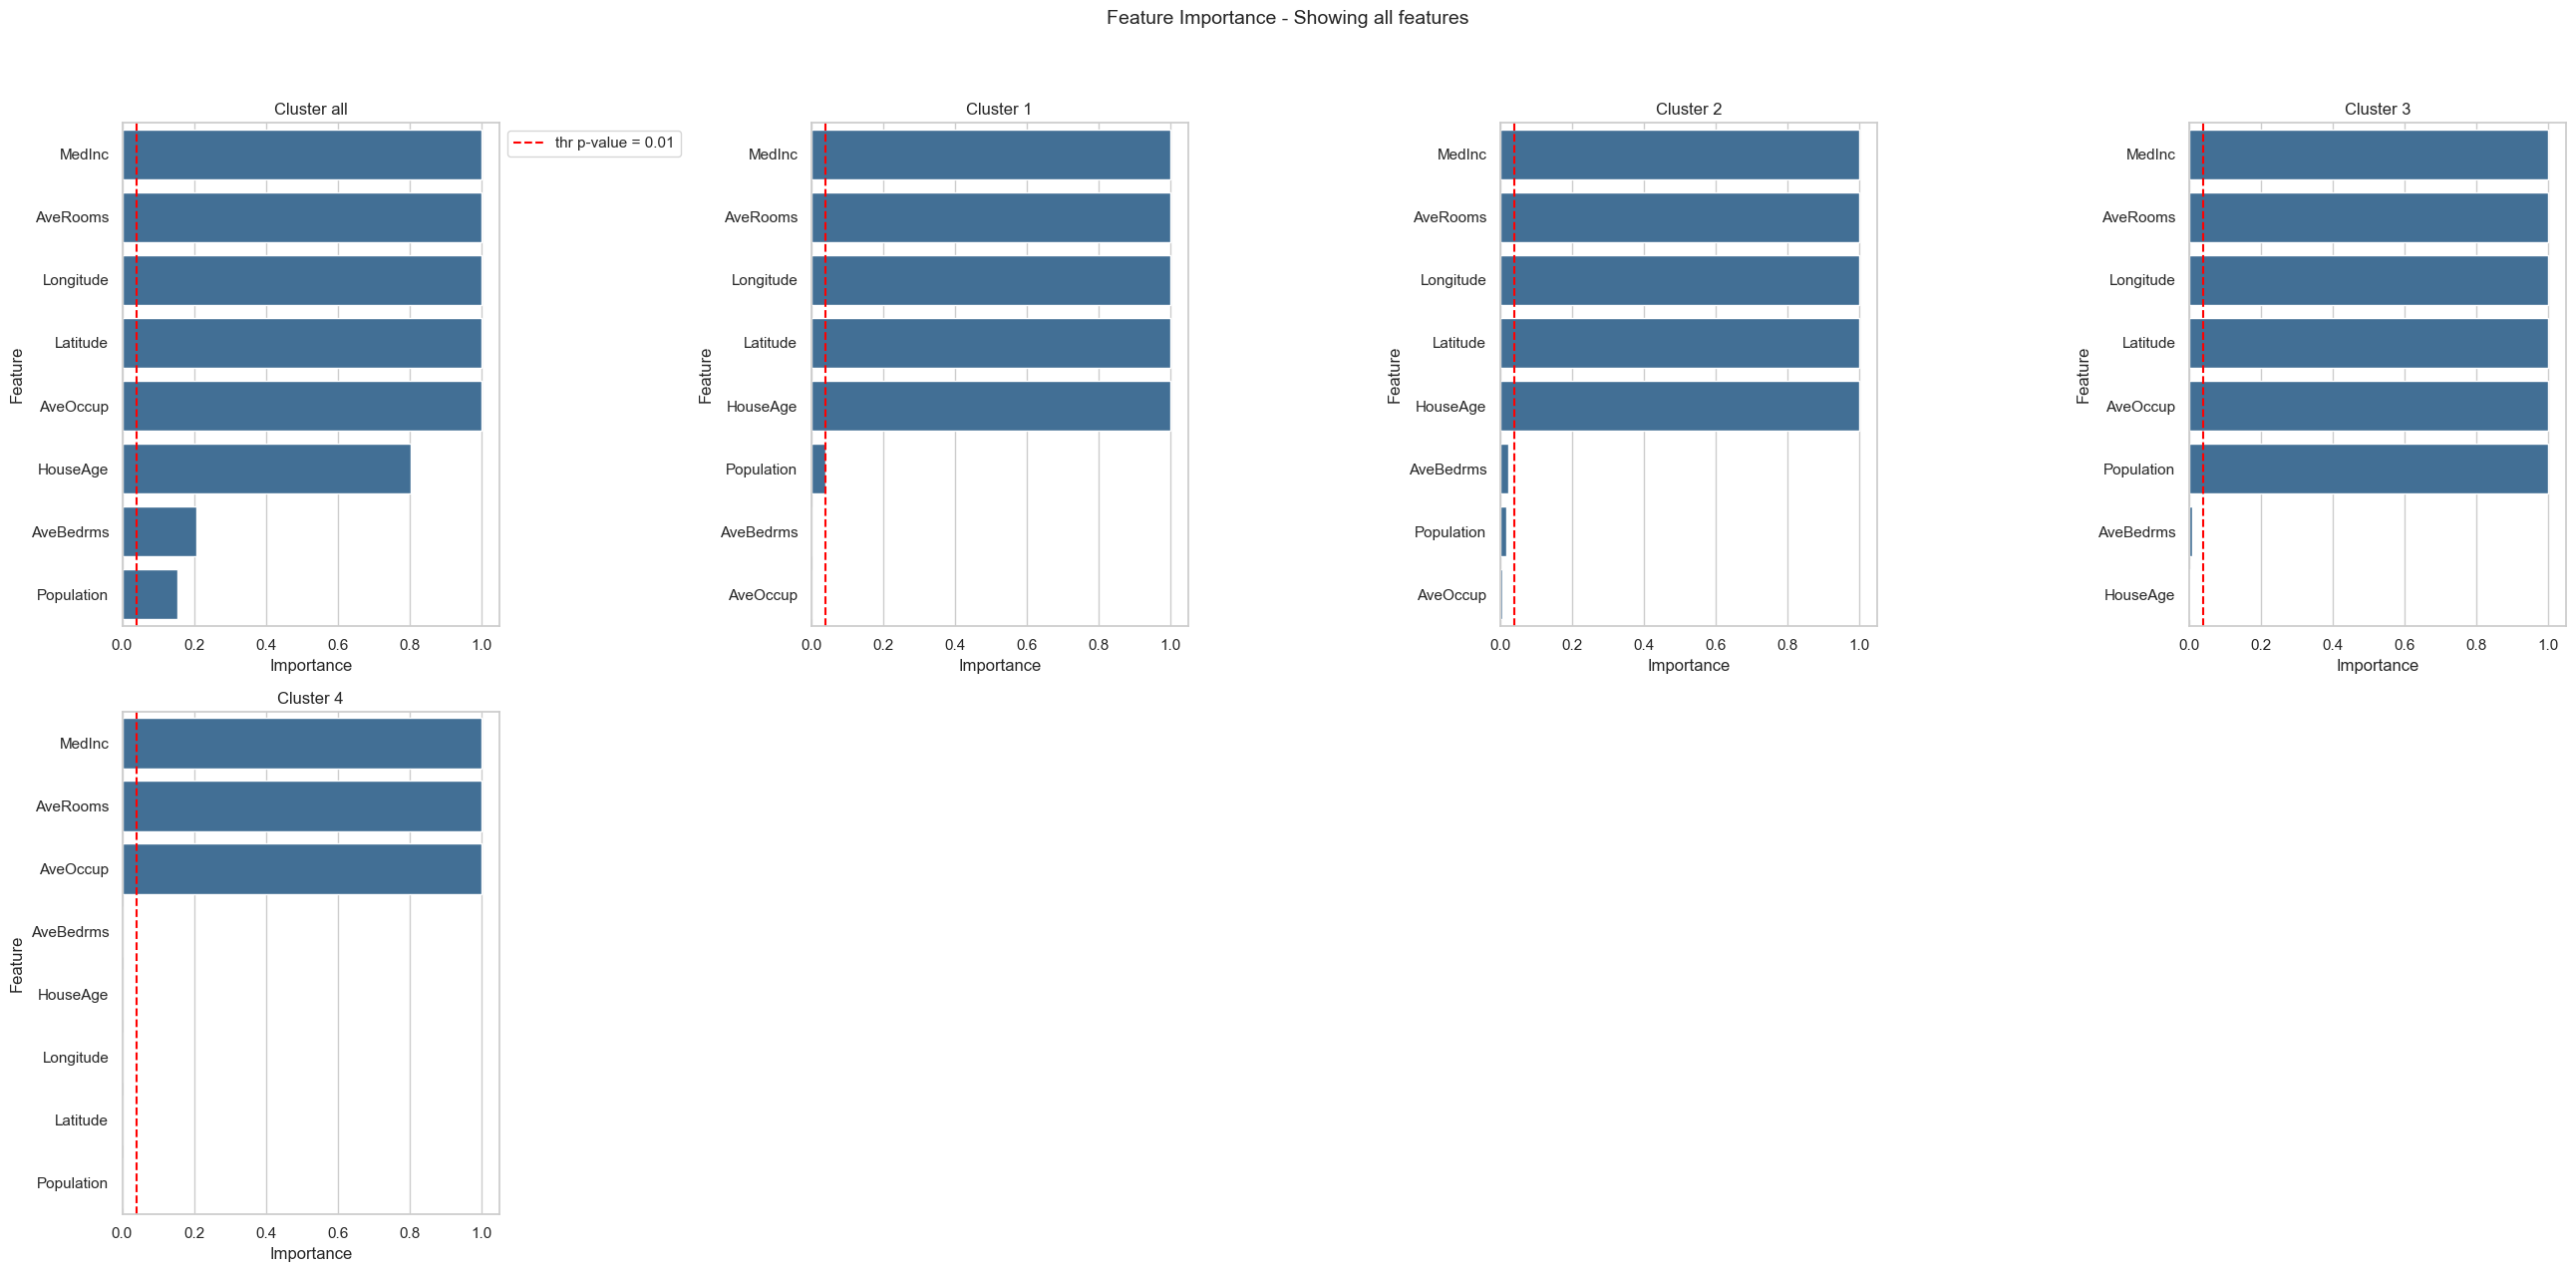

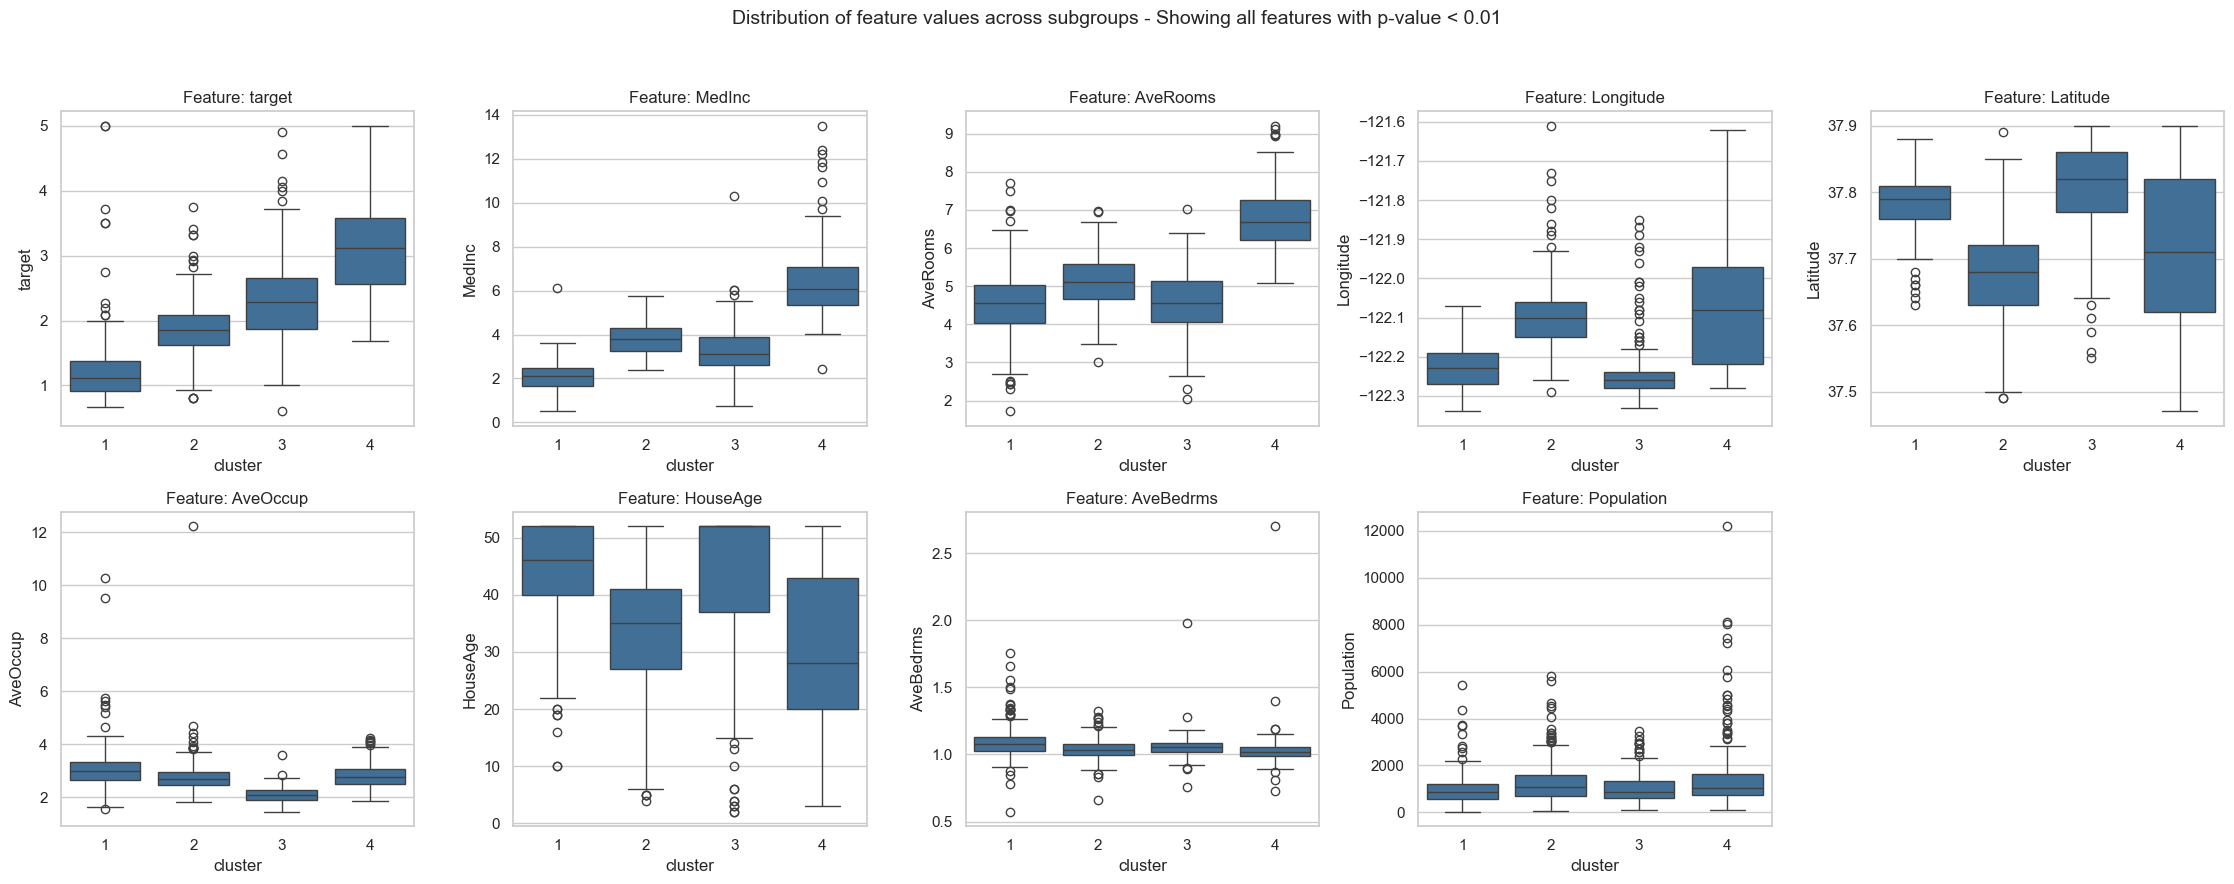

/Users/lisa.barros/Desktop/fg-clustering/fgclustering/plotting.py:150: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_heatmap = pd.concat(


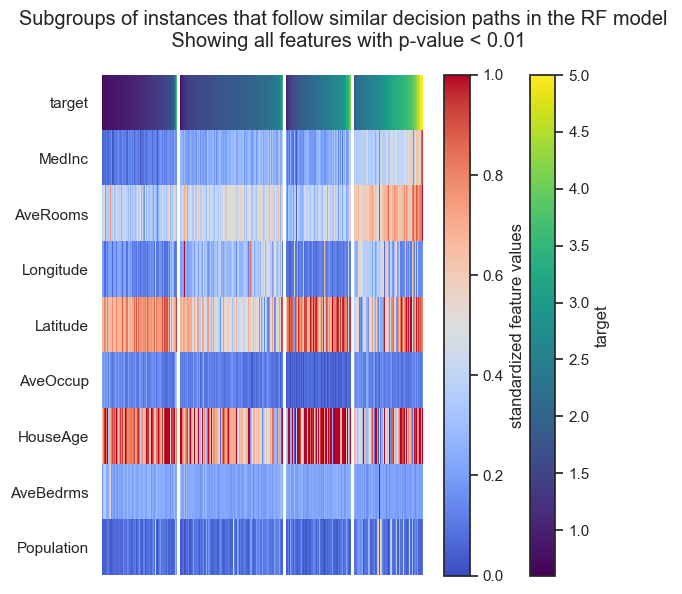

In [17]:
fgc.plot_feature_importance(thr_pvalue=0.01)
fgc.plot_decision_paths(thr_pvalue=0.01, num_cols = 5) #only plot relevant features

From the resulting plots we can draw the following conclusions:

We have two clusters (cluster 0 and 3) which represent the extremes in the dataset, i.e. houses with very low or very high house values. The lowly valued house blocks are on average occupied by people with low median income, are located in the city center (according to long/lat) and have a high house age. In contrast, the highly valued house blocks are on average occupied by people with high median income, have many rooms but a low house age and are located outside of the city center towards the mountains (according to long/lat). The remaining two clusters (cluster 1 and 2) represent houses with intermediate values. The house blocks of both clusters are occupied by middle class people with a middle medium income, hence, those two cluster can't be distinguished by income alone. Intereastingly, the house blocks of cluster 1 have more rooms and are occupied by more people than the house blocks in cluster 2. Looking at the long/lat we can see that the house blocks of cluster 2 are located on the city center and are older, while house blocks of cluster 1 are newer and located ouside the city center but closer to the airport and further away from the mountains than the house blocks of cluster 3, which are the highly valued houses.

In conclusion, we can hypothesize that lowly valued older house blocks are located in the city center and occupied by low income people with higher occupancy and less number of rooms. Then we have more highly valued older house blocks in the city center which are occupied by middle income people, who live most likely in a single or couple household. In the same value range we have newer house blocks that are located outside the city center (but close to an airport) and are occupied by middle income people, who live most likely in a family household with more than 2 people. Last, we have the highly valued newer house blocks that have many rooms, are occupied by high income people and are located outside the city, close to the mountains but further away from the airport.

The clusters of intermediate valued houses nicely show why a Random Forest model would outperform a linear model in this use-case. We can see that there is no linear relation between house values and *Latitude* / *Longitude* as well as *HouseAge*.